# DIP

## Import libs

In [13]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import numpy as np
from models import *

import torch
import torch.optim

from skimage.metrics import peak_signal_noise_ratio, structural_similarity 
from utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

imsize =-1
PLOT = True
sigma = 25
sigma_ = sigma/255.

torch.cuda.is_available()

True

## Load image

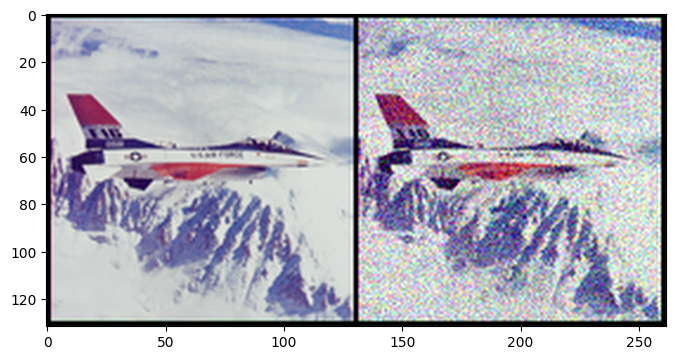

array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.69803923, ..., 0.57025474,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.6666667 , ..., 0.50047207,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.6117647 , ..., 0.79060537,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.6392157 , ..., 0.6156927 ,
         0.        , 0.        ],
        [0. 

In [14]:
fname = './F16_GT.png'

# Add synthetic noise
img_pil = crop_image(get_image(fname, imsize)[0], d=32)

# resize to 128 128
img_pil = img_pil.resize((128,128))
img_np = pil_to_np(img_pil)
    
img_noisy_pil, img_noisy_np = get_noisy_image(img_np, sigma_)
    
plot_image_grid([img_np, img_noisy_np], 4, 6)

## Setup

In [15]:
INPUT = 'noise' # 'meshgrid'
pad = 'reflection'
OPT_OVER = 'net' # 'net,input'

reg_noise_std = 1./30. # set to 1./20. for sigma=50
LR = 0.01

OPTIMIZER='adam' # 'LBFGS'
show_every = 100
exp_weight= 0.99

num_iter = 500
input_depth = 32 
figsize = 4 
    
    
net = get_net(input_depth, 'skip', pad,
                  skip_n33d=128, 
                  skip_n33u=128, 
                  skip_n11=4, 
                  num_scales=5,
                  upsample_mode='bilinear').type(dtype)

net_input = get_noise(input_depth, INPUT, (img_pil.size[1], img_pil.size[0])).type(dtype).detach()

# Compute number of parameters
s  = sum([np.prod(list(p.size())) for p in net.parameters()]); 
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_noisy_torch = np_to_torch(img_noisy_np).type(dtype)

Number of params: 2217831


## Optimize

Starting optimization with ADAM


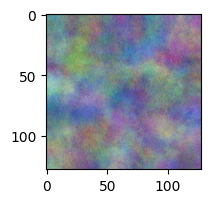

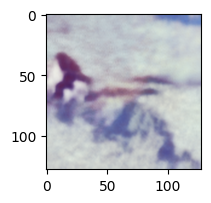

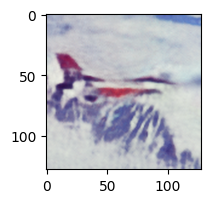

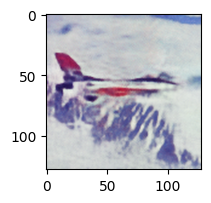

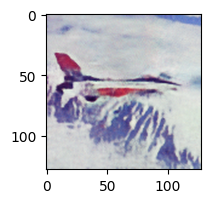

In [16]:
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()
last_net = None
psrn_noisy_last = 0

i = 0
def closure():
    
    global i, psrn_noisy_last, last_net, net_input
    
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
    
    out = net(net_input)
    

    total_loss = mse(out, img_noisy_torch)
    total_loss.backward()
        
    
    psrn_noisy = peak_signal_noise_ratio(img_noisy_np, out.detach().cpu().numpy()[0]) 
    psrn_gt    = peak_signal_noise_ratio(img_np, out.detach().cpu().numpy()[0]) 
    ssim = structural_similarity(img_np, out.detach().cpu().numpy()[0], win_size=7,channel_axis=0, data_range=1.0, multichannel=True)

    print ('Iteration %05d    Loss %f   PSNR: %f   SSIM: %f' % (i, total_loss.item(), psrn_gt, ssim), '\r', end='')
    if  PLOT and i % show_every == 0:
        out_np = torch_to_np(out)
        plot_image_grid([np.clip(out_np, 0, 1)])
        
        
    
    # Backtracking
    if i % show_every:
        if psrn_noisy - psrn_noisy_last < -5: 
            print('Falling back to previous checkpoint.')

            for new_param, net_param in zip(last_net, net.parameters()):
                net_param.data.copy_(new_param.cuda())

            return total_loss*0
        else:
            last_net = [x.detach().cpu() for x in net.parameters()]
            psrn_noisy_last = psrn_noisy
            
    i += 1

    return total_loss

p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

## Prior

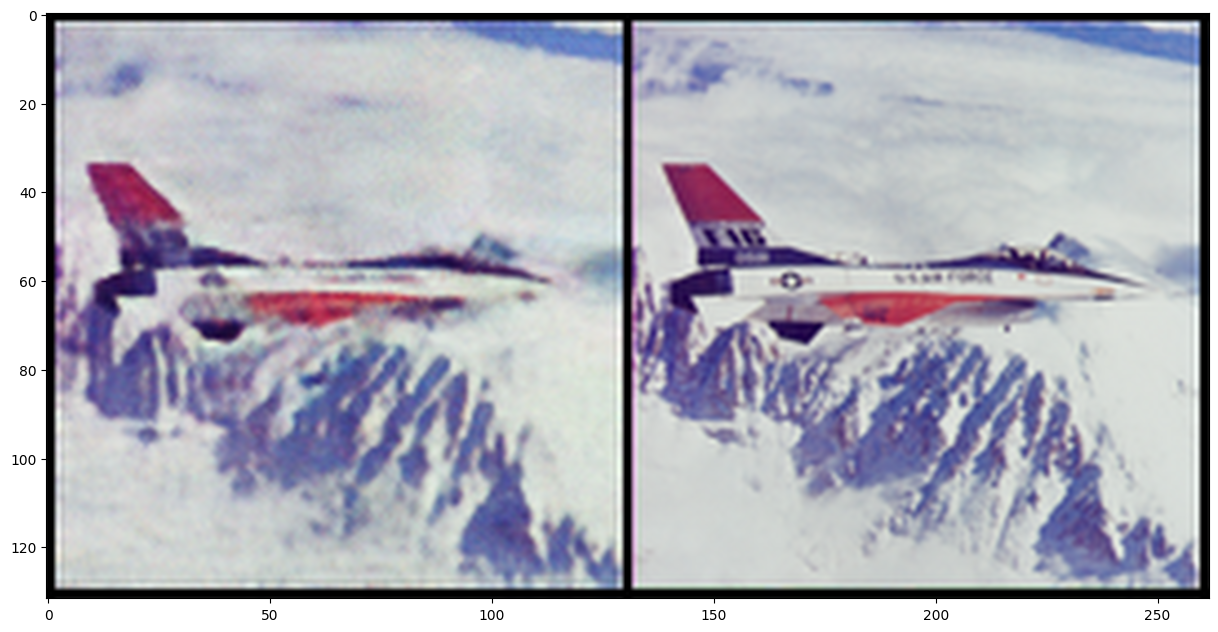

In [17]:
if num_iter == 0:
    out_np = img_noisy_np
else:
    out_np = torch_to_np(net(net_input))
q = plot_image_grid([np.clip(out_np, 0, 1), img_np], factor=13)

plt.imsave(f'prior.png', np.clip(out_np, 0, 1).transpose(1, 2, 0))

# DDPM

## import libraries


In [18]:
import torch
from torchvision import transforms
from PIL import Image
from denoising_diffusion_pytorch import Unet, GaussianDiffusion
import os
from IPython.display import display

## Setup


In [22]:
# Check if GPU is available

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Using device:', device)

# Load the Lena image from the data folder
img_path = "./prior.png"
img = Image.open(img_path).convert("RGB")

# Preprocess the image
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

img_tensor = transform(img).unsqueeze(0).to(device)  # Add batch dimension
img_tensor = img_tensor * 2 - 1  # Normalize to [-1, 1]

# Initialize the model
model = Unet(
    dim=64,
    dim_mults=(1, 2, 4, 8),
    flash_attn=True
).to(device)

diffusion = GaussianDiffusion(
    model,
    image_size=128,
    timesteps=1000    # number of steps
).to(device)

# Define the training loop
optimizer = torch.optim.Adam(diffusion.parameters(), lr=1e-4)
num_epochs = 15000

Using device: cuda


## training loop

sampling loop time step: 100%|██████████| 1000/1000 [00:24<00:00, 41.37it/s]

Epoch 500/15000, Loss: 0.02191983349621296, PSNR: 14.844128560942831, SSIM: 0.17574922740459442


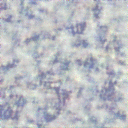

sampling loop time step: 100%|██████████| 1000/1000 [00:24<00:00, 40.38it/s]

Epoch 1000/15000, Loss: 0.22104986011981964, PSNR: 12.318737329848009, SSIM: 0.17128823697566986


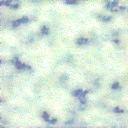

sampling loop time step: 100%|██████████| 1000/1000 [00:22<00:00, 43.91it/s]

Epoch 1500/15000, Loss: 0.02249496430158615, PSNR: 14.244666062554847, SSIM: 0.20572732388973236


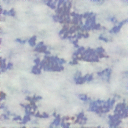

sampling loop time step: 100%|██████████| 1000/1000 [00:22<00:00, 44.24it/s]

Epoch 2000/15000, Loss: 0.06064421311020851, PSNR: 14.272343128829, SSIM: 0.2039676457643509


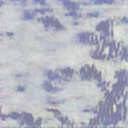

sampling loop time step: 100%|██████████| 1000/1000 [00:22<00:00, 44.12it/s]

Epoch 2500/15000, Loss: 0.005317348055541515, PSNR: 14.602251373546515, SSIM: 0.30526065826416016


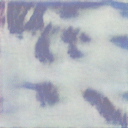

sampling loop time step: 100%|██████████| 1000/1000 [00:22<00:00, 44.36it/s]

Epoch 3000/15000, Loss: 0.001295838737860322, PSNR: 15.954031243335427, SSIM: 0.33934998512268066


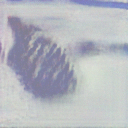

sampling loop time step: 100%|██████████| 1000/1000 [00:22<00:00, 44.80it/s]

Epoch 3500/15000, Loss: 0.017537016421556473, PSNR: 14.898154830265007, SSIM: 0.34704628586769104


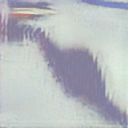

sampling loop time step: 100%|██████████| 1000/1000 [00:22<00:00, 44.31it/s]

Epoch 4000/15000, Loss: 0.0030457654502242804, PSNR: 15.36766500647989, SSIM: 0.4232077896595001


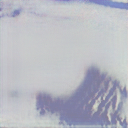

sampling loop time step: 100%|██████████| 1000/1000 [00:22<00:00, 43.88it/s]

Epoch 4500/15000, Loss: 0.027882177382707596, PSNR: 14.921330295693231, SSIM: 0.34805169701576233


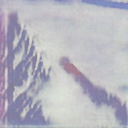

sampling loop time step: 100%|██████████| 1000/1000 [00:22<00:00, 44.29it/s]

Epoch 5000/15000, Loss: 0.030299020931124687, PSNR: 17.146671024682725, SSIM: 0.5181527733802795


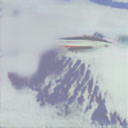

sampling loop time step: 100%|██████████| 1000/1000 [00:23<00:00, 43.44it/s]

Epoch 5500/15000, Loss: 0.0045737214386463165, PSNR: 17.373702004887136, SSIM: 0.600368082523346


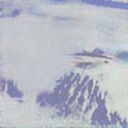

sampling loop time step: 100%|██████████| 1000/1000 [00:22<00:00, 44.51it/s]

Epoch 6000/15000, Loss: 0.010692145675420761, PSNR: 14.932863083595432, SSIM: 0.28631457686424255


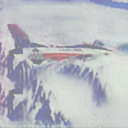

sampling loop time step: 100%|██████████| 1000/1000 [00:22<00:00, 44.17it/s]

Epoch 6500/15000, Loss: 0.0023413021117448807, PSNR: 16.62094618300617, SSIM: 0.4851260185241699


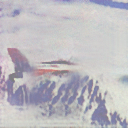

sampling loop time step: 100%|██████████| 1000/1000 [00:22<00:00, 44.32it/s]

Epoch 7000/15000, Loss: 0.002305877860635519, PSNR: 17.506317765676883, SSIM: 0.588786244392395


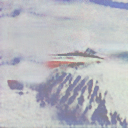

sampling loop time step: 100%|██████████| 1000/1000 [00:22<00:00, 44.33it/s]

Epoch 7500/15000, Loss: 0.0010024836519733071, PSNR: 16.936192602507944, SSIM: 0.5301794409751892


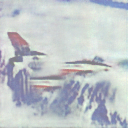

sampling loop time step: 100%|██████████| 1000/1000 [00:22<00:00, 44.44it/s]

Epoch 8000/15000, Loss: 0.03073282167315483, PSNR: 18.25356512232471, SSIM: 0.6187285780906677


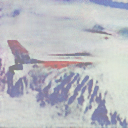

sampling loop time step: 100%|██████████| 1000/1000 [00:22<00:00, 44.44it/s]

Epoch 8500/15000, Loss: 0.01684025302529335, PSNR: 18.89825015479771, SSIM: 0.6904211640357971


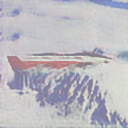

sampling loop time step: 100%|██████████| 1000/1000 [00:22<00:00, 44.07it/s]

Epoch 9000/15000, Loss: 0.0005861065583303571, PSNR: 17.44300934530646, SSIM: 0.557319164276123


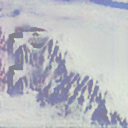

sampling loop time step: 100%|██████████| 1000/1000 [00:23<00:00, 42.35it/s]

Epoch 9500/15000, Loss: 0.0017965215956792235, PSNR: 19.343593201548362, SSIM: 0.6604675650596619


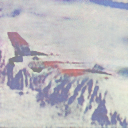

sampling loop time step: 100%|██████████| 1000/1000 [00:24<00:00, 41.54it/s]

Epoch 10000/15000, Loss: 0.002282953355461359, PSNR: 18.894008820788063, SSIM: 0.6156644225120544


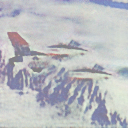

sampling loop time step: 100%|██████████| 1000/1000 [00:24<00:00, 40.96it/s]

Epoch 10500/15000, Loss: 0.00045206674258224666, PSNR: 19.27573031840215, SSIM: 0.6735608577728271


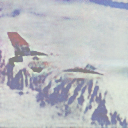

sampling loop time step: 100%|██████████| 1000/1000 [00:24<00:00, 41.16it/s]

Epoch 11000/15000, Loss: 0.0035144465509802103, PSNR: 15.915383070606456, SSIM: 0.45813336968421936


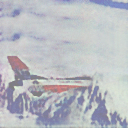

sampling loop time step: 100%|██████████| 1000/1000 [00:22<00:00, 43.65it/s]

Epoch 11500/15000, Loss: 0.00024219824990723282, PSNR: 21.603004994079264, SSIM: 0.7676331996917725


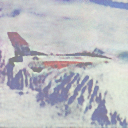

sampling loop time step: 100%|██████████| 1000/1000 [00:23<00:00, 43.43it/s]


Epoch 12000/15000, Loss: 0.029767317697405815, PSNR: 18.5407358849775, SSIM: 0.6807481646537781


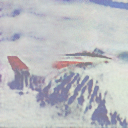

sampling loop time step: 100%|██████████| 1000/1000 [00:27<00:00, 36.22it/s]

Epoch 12500/15000, Loss: 0.00019938533660024405, PSNR: 17.085735278152146, SSIM: 0.5301832556724548


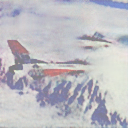

sampling loop time step: 100%|██████████| 1000/1000 [00:22<00:00, 43.60it/s]

Epoch 13000/15000, Loss: 0.00041845065425150096, PSNR: 18.26093136752715, SSIM: 0.5978383421897888


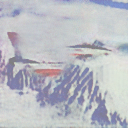

sampling loop time step: 100%|██████████| 1000/1000 [00:26<00:00, 37.89it/s]

Epoch 13500/15000, Loss: 0.0002184927143389359, PSNR: 17.217565751818405, SSIM: 0.5354611277580261


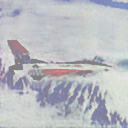

sampling loop time step: 100%|██████████| 1000/1000 [00:37<00:00, 26.32it/s]

Epoch 14000/15000, Loss: 0.0011431574821472168, PSNR: 19.58736968544375, SSIM: 0.6727777123451233


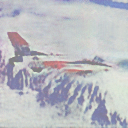

sampling loop time step: 100%|██████████| 1000/1000 [00:26<00:00, 37.57it/s]

Epoch 14500/15000, Loss: 0.000478980946354568, PSNR: 16.739326407368903, SSIM: 0.5104908347129822


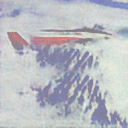

sampling loop time step: 100%|██████████| 1000/1000 [00:23<00:00, 42.63it/s]

Epoch 15000/15000, Loss: 0.004586101975291967, PSNR: 20.157268497398814, SSIM: 0.6989085078239441


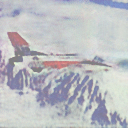

In [23]:
for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss = diffusion(img_tensor)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 500 == 0:
        # Sample images
        sampled_images = diffusion.sample(batch_size=1)
        
        # Ensure the sampled images have the correct shape
        sampled_images = sampled_images.cpu().detach()
        sampled_image = sampled_images[0]  # Remove batch dimension

        # Denormalize the image from [-1, 1] to [0, 1]
        sampled_image = (sampled_image + 1) / 2
        sampled_image = sampled_image.clamp(0, 1)
        
        # calculate PSNR_noisy PSRN_gt
        psnr = peak_signal_noise_ratio(img_np, sampled_image.cpu().detach().numpy())

        # calculate ssim
        ssim = structural_similarity(img_np, sampled_image.cpu().detach().numpy(), win_size=7,channel_axis=0, data_range=1.0, multichannel=True)

        
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}, PSNR: {psnr}, SSIM: {ssim}")

        # Convert to PIL Image
        sampled_image_pil = transforms.ToPILImage()(sampled_image)
        display(sampled_image_pil)
        
        # torch.save(diffusion.state_dict(), f"diffusion_model_epoch_{epoch + 1}.pth")
        # sampled_image_pil.save(f"sampled_image_epoch_{epoch + 1}.png")



sampling loop time step: 100%|██████████| 1000/1000 [00:24<00:00, 40.45it/s]

PSNR: 21.602136405234855, SSIM: 0.7646851539611816


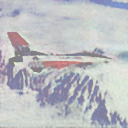

In [25]:
if num_epochs == 0:
    plt.imsave(f'result.png', np.clip(out_np, 0, 1).transpose(1, 2, 0))
else:
    sampled_images = diffusion.sample(batch_size=1)
            
    # Ensure the sampled images have the correct shape
    sampled_images = sampled_images.cpu().detach()
    sampled_image = sampled_images[0]  # Remove batch dimension

    # Denormalize the image from [-1, 1] to [0, 1]
    sampled_image = (sampled_image + 1) / 2
    sampled_image = sampled_image.clamp(0, 1)
            
    # calculate PSNR_noisy PSRN_gt
    psnr = peak_signal_noise_ratio(img_np, sampled_image.cpu().detach().numpy())

    # calculate ssim
    ssim = structural_similarity(img_np, sampled_image.cpu().detach().numpy(), win_size=7,channel_axis=0, data_range=1.0, multichannel=True)

            
    print(f"PSNR: {psnr}, SSIM: {ssim}")

    # Convert to PIL Image
    sampled_image_pil = transforms.ToPILImage()(sampled_image)
    display(sampled_image_pil)
    sampled_image_pil.save(f"result.png")